In [1]:
import pandas as pd
import os
from datetime import datetime, timedelta

print('hello')

hello


In [2]:
# Read CSV file

pname='patient12'
pathlete= 0
pit='18:13:00'
# Define start time for filtering (you can modify this)
#start_time = '12:49:00'  # Filter

csv_files = r'alldata/test39_39_20251124_151957_IBI_patient_11_12.csv'

# Find txt files for later use
txt_files = 'alldata/deary_liewald.data.2025-11-24--17-31_patient12.txt'

#################

df_csv = pd.read_csv(csv_files)
ita_csv=csv_files[27:33]
#print(ita_csv)

ita_csv=ita_csv[:2]+':'+ita_csv[2:4]+':'+ita_csv[4:6]
ita_csv= datetime.strptime(ita_csv, '%H:%M:%S').strftime('%H:%M:%S')

# Preprocess CSV data - separate values by semicolon and use line 2 as headers
with open(csv_files, 'r') as file:
    lines = file.readlines()
    
# Use line 2 (index 2) as headers - it contains "RR;Artifact corrected RR;Raw artifact;"
headers = lines[2].strip().split(';')
headers = [h.strip() for h in headers if h.strip()][:3]  # Take only first 3 non-empty headers

# Process data lines starting from line 3
csv_data = []
for line in lines[3:]:
    values = line.strip().split(';')
    if len(values) >= 3 and values[0]:  # Ensure we have at least 3 values and first is not empty
        csv_data.append(values[:3])  # Take only first 3 columns

# Create new dataframe with proper structure
df_csv = pd.DataFrame(csv_data, columns=headers)
print(f"Preprocessed CSV file: {csv_files[0]}")
print(df_csv.head())
print(f"Shape: {df_csv.shape}")
print(f"Columns: {df_csv.columns.tolist()}")

######################

ita_txt=txt_files[39:44]+':00'
print(ita_txt)
ita_txt=ita_txt.replace('-',':')
print(ita_txt)
ita_txt=datetime.strptime(ita_txt, '%H:%M:%S').strftime('%H:%M:%S')

# Read TXT file
df_txt = pd.read_csv(txt_files, delimiter=' ', header=None)
# Rename columns for TXT dataframe
df_txt.columns = ['block', 'dtdisplay', 'answer', 'RT', 'mark']
print(f"Updated TXT file: {txt_files}")
print(df_txt.head())
print(f"Shape: {df_txt.shape}")
print(f"Columns: {df_txt.columns.tolist()}")

# The two df are the df_csv 
# -> come from sensor -> multiple users
# and df_txt 
# -> come from test -> single user

# Remove NaN values from dataframes
print("Before removing NaN values:")
print(f"df_csv shape: {df_csv.shape}")
print(f"df_txt shape: {df_txt.shape}")

# Remove NaN values from df_csv
df_csv = df_csv.dropna()

# Remove NaN values from df_txt (if any)
df_txt = df_txt.dropna()

print("\nAfter removing NaN values:")
print(f"df_csv shape: {df_csv.shape}")
print(f"df_txt shape: {df_txt.shape}")


Preprocessed CSV file: a
    RR Artifact corrected RR Raw artifact
0  687                   687            0
1  734                   734            0
2  738                   738            0
3  750                   750            0
4  690                   690            0
Shape: (4632, 3)
Columns: ['RR', 'Artifact corrected RR', 'Raw artifact']
17-31:00
17:31:00
Updated TXT file: alldata/deary_liewald.data.2025-11-24--17-31_patient12.txt
               block  dtdisplay  answer   RT  mark
0  dlchoice_training       2752       0  453     1
1  dlchoice_training       2767    -150  433     1
2  dlchoice_training       1237     150  522     1
3  dlchoice_training       2483    -150  412     1
4  dlchoice_training       1781       0  404     1
Shape: (354, 5)
Columns: ['block', 'dtdisplay', 'answer', 'RT', 'mark']
Before removing NaN values:
df_csv shape: (4632, 3)
df_txt shape: (354, 5)

After removing NaN values:
df_csv shape: (4632, 3)
df_txt shape: (354, 5)


In [3]:
print(ita_txt, ita_csv)

17:31:00 15:19:57


In [4]:
import numpy as np

# Convert ita_csv and ita_txt to datetime objects for calculation
ita_csv_dt = datetime.strptime(ita_csv, '%H:%M:%S')
#ita_txt_dt = datetime.strptime(ita_txt, '%H:%M:%S')

# For df_csv: convert 'Artifact corrected RR' to numeric and calculate cumulative time
df_csv['Artifact corrected RR'] = pd.to_numeric(df_csv['Artifact corrected RR'])
df_csv = df_csv.dropna()

cumulative_ms_csv = df_csv['Artifact corrected RR'].cumsum()
#print(cumulative_ms_csv)
time_column_csv = []

for ms in cumulative_ms_csv:
    new_time = ita_csv_dt + timedelta(milliseconds=ms)
    time_column_csv.append(new_time.strftime('%H:%M:%S.%f')[:-3])  # Include milliseconds

# Insert time column at the beginning of df_csv
# Check if 'Time' column already exists and remove it if it does
if 'Time' not in df_csv.columns:
    df_csv.insert(0, 'Time', time_column_csv)

'''# For df_txt: calculate cumulative time from dtdisplay
cumulative_ms_txt = df_txt['dtdisplay'].cumsum()
time_column_txt = []

for ms in cumulative_ms_txt:
    new_time = ita_txt_dt + timedelta(milliseconds=ms)
    time_column_txt.append(new_time.strftime('%H:%M:%S.%f')[:-3])  # Include milliseconds

# Insert time column at the beginning of df_txt
if 'Time' not in df_txt.columns:
    df_txt.insert(0, 'Time', time_column_txt)'''

# Print first 10 rows of each dataframe
print("First 10 rows of df_csv:")
print(df_csv.head(15))
print("\nFirst 10 rows of df_txt:")
print(df_txt.head(15))

# Shift time columns by one position and fill first with initial times
df_csv['Time'] = [ita_csv] + df_csv['Time'].iloc[:-1].tolist()
#df_txt['Time'] = [ita_txt] + df_txt['Time'].iloc[:-1].tolist()

print("After shifting - First 10 rows of df_csv:")
print(df_csv.head(10))
print("\nAfter shifting - First 10 rows of df_txt:")
print(df_txt.head(10))


First 10 rows of df_csv:
            Time   RR  Artifact corrected RR Raw artifact
0   15:19:57.687  687                    687            0
1   15:19:58.421  734                    734            0
2   15:19:59.159  738                    738            0
3   15:19:59.909  750                    750            0
4   15:20:00.599  690                    690            0
5   15:20:01.292  693                    693            0
6   15:20:02.011  719                    719            0
7   15:20:02.776  765                    765            0
8   15:20:03.515  739                    739            0
9   15:20:04.252  737                    737            0
10  15:20:04.996  744                    744            0
11  15:20:05.708  712                    712            0
12  15:20:06.373  665                    665            0
13  15:20:07.017  644                    644            0
14  15:20:07.666  649                    649            0

First 10 rows of df_txt:
                block

In [5]:
# Get info about df_csv
print("=== CSV DataFrame Info ===")
print(f"Number of rows: {len(df_csv)}")
print(f"Number of columns: {len(df_csv.columns)}")
print(f"First Time value: {df_csv['Time'].iloc[0]}")
print(f"Last Time value: {df_csv['Time'].iloc[-1]}")

#df_csv['Time'].iloc[0]=start_time

# Calculate duration for CSV
first_time_csv = datetime.strptime(df_csv['Time'].iloc[0], '%H:%M:%S')
last_time_csv = datetime.strptime(df_csv['Time'].iloc[-1], '%H:%M:%S.%f')
duration_csv = last_time_csv - first_time_csv
print(f"Duration: {duration_csv}")

# Check for NaN values in df_csv
print(f"NaN values per column:")
print(df_csv.isnull().sum())

print("\n" + "="*50 + "\n")

# Get info about df_txt
print("=== TXT DataFrame Info ===")
print(f"Number of rows: {len(df_txt)}")
print(f"Number of columns: {len(df_txt.columns)}")
#print(f"First Time value: {df_txt['Time'].iloc[0]}")
#print(f"Last Time value: {df_txt['Time'].iloc[-1]}")

# Calculate duration for TXT
#first_time_txt = datetime.strptime(df_txt['Time'].iloc[0], '%H:%M:%S')
#last_time_txt = datetime.strptime(df_txt['Time'].iloc[-1], '%H:%M:%S.%f')
#duration_txt = last_time_txt - first_time_txt
#print(f"Duration: {duration_txt}")

# Check for NaN values in df_txt
print(f"NaN values per column:")
print(df_txt.isnull().sum())

print(f"\nData types:")
print(df_txt.dtypes)

=== CSV DataFrame Info ===
Number of rows: 4632
Number of columns: 4
First Time value: 15:19:57
Last Time value: 16:17:01.921
Duration: 0:57:04.921000
NaN values per column:
Time                     0
RR                       0
Artifact corrected RR    0
Raw artifact             0
dtype: int64


=== TXT DataFrame Info ===
Number of rows: 354
Number of columns: 5
NaN values per column:
block        0
dtdisplay    0
answer       0
RT           0
mark         0
dtype: int64

Data types:
block        object
dtdisplay     int64
answer        int64
RT            int64
mark          int64
dtype: object


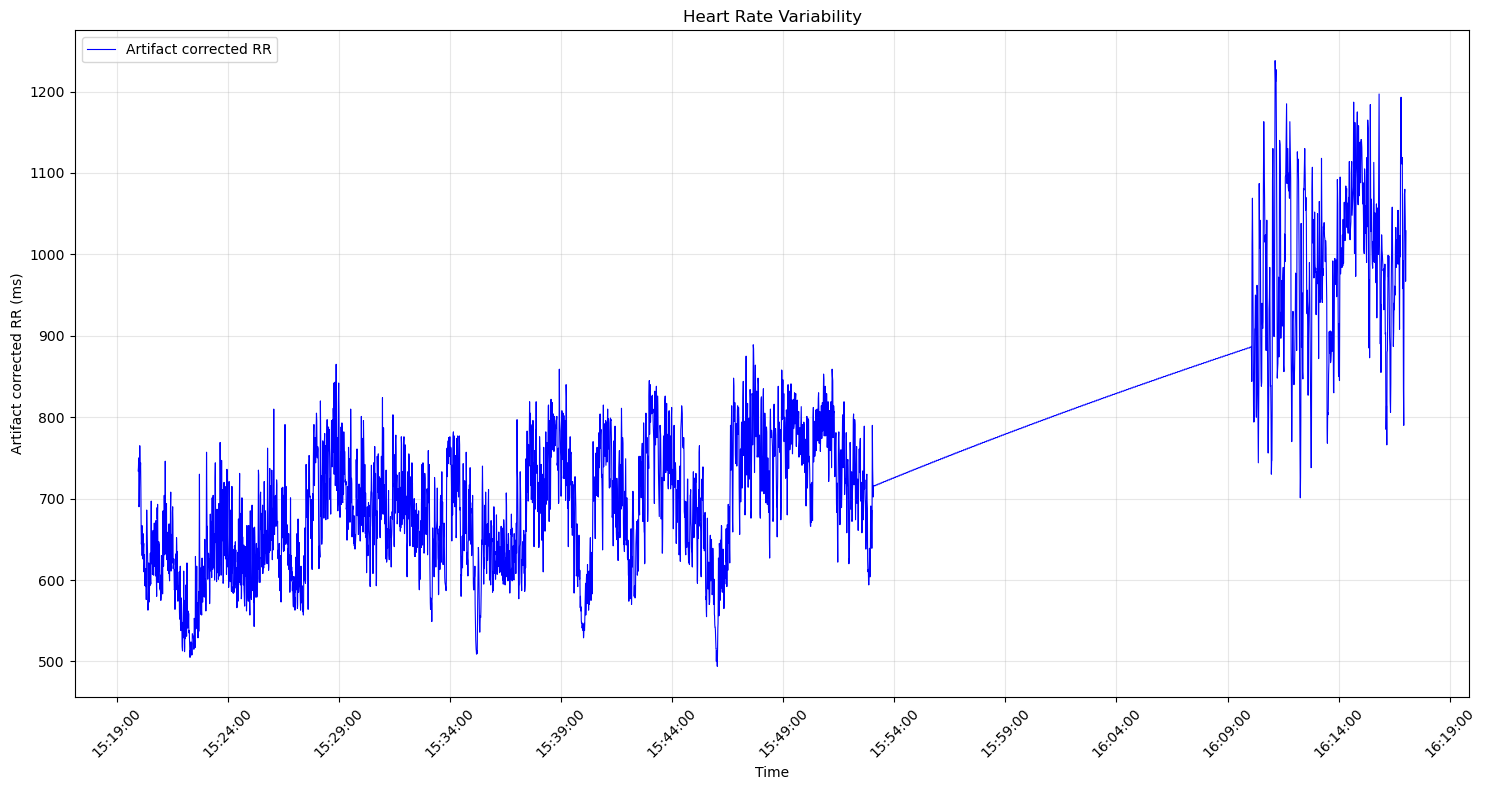

Plots saved to 'patsfilter/patient12_heart_rate_variability.png' and 'patsfilter/patient12_event_marks.png'


In [6]:
import matplotlib.pyplot as plt

# Convert Time columns to datetime for proper plotting
df_csv['Time_dt'] = pd.to_datetime(df_csv['Time'], format='%H:%M:%S.%f', errors='coerce')
#df_txt['Time_dt'] = pd.to_datetime(df_txt['Time'], format='%H:%M:%S.%f', errors='coerce')

# Set the first value of Time_dt columns to avoid NaT values
#df_csv.loc[0, 'Time_dt'] = pd.to_datetime(ita_csv, format='%H:%M:%S')
#df_txt.loc[0, 'Time_dt'] = pd.to_datetime(ita_txt, format='%H:%M:%S')

# Create the plot
# Create two separate figures
fig1, ax1 = plt.subplots(figsize=(15, 8))
#fig2, ax2 = plt.subplots(figsize=(15, 8))

# Figure 1: Heart Rate Variability
ax1.plot(df_csv['Time_dt'], df_csv['Artifact corrected RR'], 'b-', linewidth=0.8, label='Artifact corrected RR')
ax1.set_xlabel('Time')
ax1.set_ylabel('Artifact corrected RR (ms)')
ax1.set_title('Heart Rate Variability')
ax1.legend()
ax1.grid(True, alpha=0.3)

'''# Add a dummy line for legend
ax2.scatter(df_txt['Time_dt'], df_txt['mark'], color='red', label='TXT Events')
ax2.set_xlabel('Time')
ax2.set_ylabel('Events')
ax2.set_title('Event Marks from TXT File')
ax2.legend()
ax2.grid(True, alpha=0.3)'''

# Format x-axis for both figures
import matplotlib.dates as mdates
#for ax in [ax1, ax2]:
for ax in [ax1]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=5))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Save the plots to the pats directory
fig1.suptitle(f'Heart Rate Variability - {pname}')
#fig2.suptitle(f'Event Marks - {pname}')

#os.makedirs('patsfilter', exist_ok=True)
#fig1.savefig(f'patsfilter/{pname}_heart_rate_variability.png', dpi=300, bbox_inches='tight')
#fig2.savefig(f'patsfilter/{pname}_event_marks.png', dpi=300, bbox_inches='tight')

print(f"Plots saved to 'patsfilter/{pname}_heart_rate_variability.png' and 'patsfilter/{pname}_event_marks.png'")

In [7]:
# FILTERING

start_time=input("Enter start time (HH:MM:SS): ")

# Convert start_time to datetime object
start_dt = datetime.strptime(start_time, '%H:%M:%S')

# Calculate end time (start + 15 minutes)
end_dt = start_dt + timedelta(minutes=15)

print(f"Filtering df_csv from {start_time} to {end_dt.strftime('%H:%M:%S')}")

# Convert Time column to datetime for comparison (handle different formats)
df_csv['Time_temp'] = pd.to_datetime(df_csv['Time'], format='%H:%M:%S', errors='coerce')
df_csv['Time_temp'] = df_csv['Time_temp'].fillna(pd.to_datetime(df_csv['Time'], format='%H:%M:%S.%f', errors='coerce'))

# Filter rows within the 15-minute window
mask = (df_csv['Time_temp'].dt.time >= start_dt.time()) & (df_csv['Time_temp'].dt.time <= end_dt.time())
df_csv_filtered = df_csv[mask].copy()

# Remove the temporary column
df_csv_filtered = df_csv_filtered.drop('Time_temp', axis=1)
df_csv = df_csv.drop('Time_temp', axis=1)

print(f"Original df_csv shape: {df_csv.shape}")
print(f"Filtered df_csv shape: {df_csv_filtered.shape}")
print(f"First time in filtered data: {df_csv_filtered['Time'].iloc[0]}")
print(f"Last time in filtered data: {df_csv_filtered['Time'].iloc[-1]}")

# Update df_csv to be the filtered version
df_csv = df_csv_filtered

print("After filtering - First 10 rows of df_csv:")
print(df_csv.head(10))

# Replace first time value with pit and recalculate subsequent times

# For df_csv
df_csv['Time'].iloc[0] = pit
pit_dt = datetime.strptime(pit, '%H:%M:%S')

# Recalculate time column for df_csv by adding Artifact corrected RR values
for i in range(1, len(df_csv)):
    prev_time = datetime.strptime(df_csv['Time'].iloc[i-1], '%H:%M:%S.%f' if '.' in df_csv['Time'].iloc[i-1] else '%H:%M:%S')
    rr_value = float(df_csv['Artifact corrected RR'].iloc[i])
    new_time = prev_time + timedelta(milliseconds=rr_value)
    df_csv.loc[df_csv.index[i], 'Time'] = new_time.strftime('%H:%M:%S.%f')[:-3]

'''# For df_txt
df_txt['Time'].iloc[0] = pit

# Recalculate time column for df_txt by adding mark values
for i in range(1, len(df_txt)):
    prev_time = datetime.strptime(df_txt['Time'].iloc[i-1], '%H:%M:%S.%f' if '.' in df_txt['Time'].iloc[i-1] else '%H:%M:%S')
    mark_value = float(df_txt['dtdisplay'].iloc[i])
    new_time = prev_time + timedelta(milliseconds=mark_value)
    df_txt.loc[df_txt.index[i], 'Time'] = new_time.strftime('%H:%M:%S.%f')[:-3]'''

print("Updated time columns:")
print("df_csv first 10 rows:")
print(df_csv.head(10))
print("\ndf_txt first 10 rows:")
print(df_txt.head(10))

Filtering df_csv from 15:37:00 to 15:52:00
Original df_csv shape: (4632, 5)
Filtered df_csv shape: (1263, 5)
First time in filtered data: 15:37:00.335
Last time in filtered data: 15:51:59.879
After filtering - First 10 rows of df_csv:
              Time   RR  Artifact corrected RR Raw artifact  \
1575  15:37:00.335  734                    702            0   
1576  15:37:01.037  722                    797            0   
1577  15:37:01.834  686                    734            0   
1578  15:37:02.568  656                    722            0   
1579  15:37:03.290  615                    686            0   
1580  15:37:03.976  579                    656            0   
1581  15:37:04.632  577                    615            0   
1582  15:37:05.247  593                    579            0   
1583  15:37:05.826  594                    577            0   
1584  15:37:06.403  641                    593            0   

                     Time_dt  
1575 1900-01-01 15:37:00.335  
1576 1900

C:\Users\georg\AppData\Local\Temp\ipykernel_27652\2502546105.py:39: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_csv['Time'].iloc[0] = pit
C:\Users\georg\AppData\Local\Temp\ipykernel_27652\2502546105.py:39: SettingWithCopyWarning: 
A val

Updated time columns:
df_csv first 10 rows:
              Time   RR  Artifact corrected RR Raw artifact  \
1575      18:13:00  734                    702            0   
1576  18:13:00.797  722                    797            0   
1577  18:13:01.531  686                    734            0   
1578  18:13:02.253  656                    722            0   
1579  18:13:02.939  615                    686            0   
1580  18:13:03.595  579                    656            0   
1581  18:13:04.210  577                    615            0   
1582  18:13:04.789  593                    579            0   
1583  18:13:05.366  594                    577            0   
1584  18:13:05.959  641                    593            0   

                     Time_dt  
1575 1900-01-01 15:37:00.335  
1576 1900-01-01 15:37:01.037  
1577 1900-01-01 15:37:01.834  
1578 1900-01-01 15:37:02.568  
1579 1900-01-01 15:37:03.290  
1580 1900-01-01 15:37:03.976  
1581 1900-01-01 15:37:04.632  
1582 1900-01-0

In [8]:
# Create lists to collect RT values for each block
block1_RT = []
block2_RT = []
block3_RT = []
block4_RT = []

# Get unique blocks to understand the structure
unique_blocks = df_txt['block'].unique()
print("Unique blocks found:", unique_blocks)

# Iterate through df_txt and collect RT values for each block
for index, row in df_txt.iterrows():
    block = row['block']
    rt_value = row['RT']
    
    if 'training' in block:
        block1_RT.append(rt_value)
    elif 'real1' in block:
        block2_RT.append(rt_value)
    elif 'real2' in block:
        block3_RT.append(rt_value)
    elif 'real3' in block:
        block4_RT.append(rt_value)

print(f"Block 1 (training) RT values: {len(block1_RT)} items")
print(f"Block 2 (real1) RT values: {len(block2_RT)} items")
print(f"Block 3 (real2) RT values: {len(block3_RT)} items")
print(f"Block 4 (real3) RT values: {len(block4_RT)} items")

print(f"\nFirst 10 RT values for each block:")
print(f"Block 1: {block1_RT[:10]}")
print(f"Block 2: {block2_RT[:10]}")
print(f"Block 3: {block3_RT[:10]}")
print(f"Block 4: {block4_RT[:10]}")

Unique blocks found: ['dlchoice_training' 'dlchoice_real1' 'dlchoice_real2' 'dlchoice_real3']
Block 1 (training) RT values: 9 items
Block 2 (real1) RT values: 116 items
Block 3 (real2) RT values: 115 items
Block 4 (real3) RT values: 114 items

First 10 RT values for each block:
Block 1: [453, 433, 522, 412, 404, 513, 400, 361, 386]
Block 2: [356, 472, 388, 357, 374, 385, 358, 409, 403, 392]
Block 3: [379, 418, 366, 335, 345, 383, 404, 367, 320, 417]
Block 4: [380, 366, 367, 334, 390, 362, 349, 393, 333, 454]


In [9]:
'''hr_baseline= np.mean(df_csv['Artifact corrected RR'].tolist()[:(len(df_csv['Artifact corrected RR'].tolist())//4)]),
hr_baseline=hr_baseline[0]
hrvalueswb=[int(i)-int(hr_baseline) for i in df_csv['Artifact corrected RR'].tolist()]
print(hrvalueswb[:10])
print(np.mean(df_csv['Artifact corrected RR'].tolist()))
print(np.mean(df_txt['RT'].tolist()))
print(block1_RT[:10])
'''

"hr_baseline= np.mean(df_csv['Artifact corrected RR'].tolist()[:(len(df_csv['Artifact corrected RR'].tolist())//4)]),\nhr_baseline=hr_baseline[0]\nhrvalueswb=[int(i)-int(hr_baseline) for i in df_csv['Artifact corrected RR'].tolist()]\nprint(hrvalueswb[:10])\nprint(np.mean(df_csv['Artifact corrected RR'].tolist()))\nprint(np.mean(df_txt['RT'].tolist()))\nprint(block1_RT[:10])\n"

In [10]:
import os
import pickle

quads=len(df_csv['Artifact corrected RR'].tolist())//4
hr_baseline= np.mean(df_csv['Artifact corrected RR'].tolist()[:quads]),
hr_baseline=hr_baseline[0]
hrvalueswb=[int(i)-int(hr_baseline) for i in df_csv['Artifact corrected RR'].tolist()]

# Create the dictionary with the requested structure
patient_data = {
    'Name': pname,  # To be filled with parameter
    'Athlete': pathlete,  # To be filled with parameter
    'real initial time': pit,  # To be filled with parameter
    'hr_time': df_csv['Time'].tolist(),
    'hr_values': df_csv['Artifact corrected RR'].tolist(),
    'hr_mean': np.mean(df_csv['Artifact corrected RR'].tolist()),
    'hr_baseline': hr_baseline,
    'hr_base': hrvalueswb,
    'hr1': df_csv['Artifact corrected RR'].tolist()[quads:2*quads],
    'hr1_mean': np.mean(df_csv['Artifact corrected RR'].tolist()[quads:2*quads]),
    'hr2': df_csv['Artifact corrected RR'].tolist()[2*quads:3*quads],
    'hr2_mean': np.mean(df_csv['Artifact corrected RR'].tolist()[2*quads:3*quads]),
    'hr3': df_csv['Artifact corrected RR'].tolist()[3*quads:],
    'hr3_mean': np.mean(df_csv['Artifact corrected RR'].tolist()[3*quads:]),
    'game mark': df_txt['mark'].tolist(),
    'RT': df_txt['RT'].tolist(),
    'RT_mean': np.mean(df_txt['RT'].tolist()),
    'RTt': block1_RT,
    'RTt_mean': np.mean(block1_RT),
    'RT1': block2_RT,
    'RT1_mean': np.mean(block2_RT),
    'RT2': block3_RT,
    'RT2_mean': np.mean(block3_RT),
    'RT3': block4_RT,
    'RT3_mean': np.mean(block4_RT),

}

# Create directory if it doesn't exist
os.makedirs('patsfilter', exist_ok=True)

# Save the dictionary to a file in the pats directory

# Save as pickle file
with open(f"patsfilter/{patient_data['Name']}.pkl", 'wb') as f:
    pickle.dump(patient_data, f)

print(f"Dictionary saved to 'patsfil/{patient_data['Name']}.pkl'")
print(f"Dictionary keys: {list(patient_data.keys())}")

Dictionary saved to 'patsfil/patient12.pkl'
Dictionary keys: ['Name', 'Athlete', 'real initial time', 'hr_time', 'hr_values', 'hr_mean', 'hr_baseline', 'hr_base', 'hr1', 'hr1_mean', 'hr2', 'hr2_mean', 'hr3', 'hr3_mean', 'game mark', 'RT', 'RT_mean', 'RTt', 'RTt_mean', 'RT1', 'RT1_mean', 'RT2', 'RT2_mean', 'RT3', 'RT3_mean']
